In [18]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from openpyxl.styles.builtins import output
from torch.nn import CrossEntropyLoss
from torch.onnx.symbolic_opset9 import permute
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torchvision
import torchvision.models as models

import torchvision.transforms as transforms


# Check device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Create transform with many parameters which help to serve for many cases

In [3]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root='../dataset', transform=transformer)

# Get split data

In [4]:
train_size = int(0.75*len(dataset))
test_size = len(dataset) - train_size

In [5]:
train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

# Create train loader

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Expolore dataset - train loader

In [7]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [8]:
class_dataset =dataset.classes
class_dataset

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0648367].


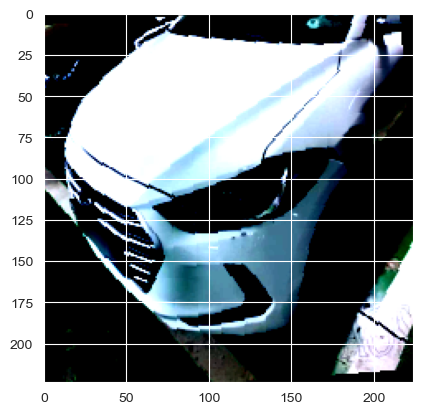

In [9]:
single_image = images[0]
single_image = single_image.permute(1,2,0)
plt.imshow(single_image)
plt.show()

# Explore images and labels from dataset


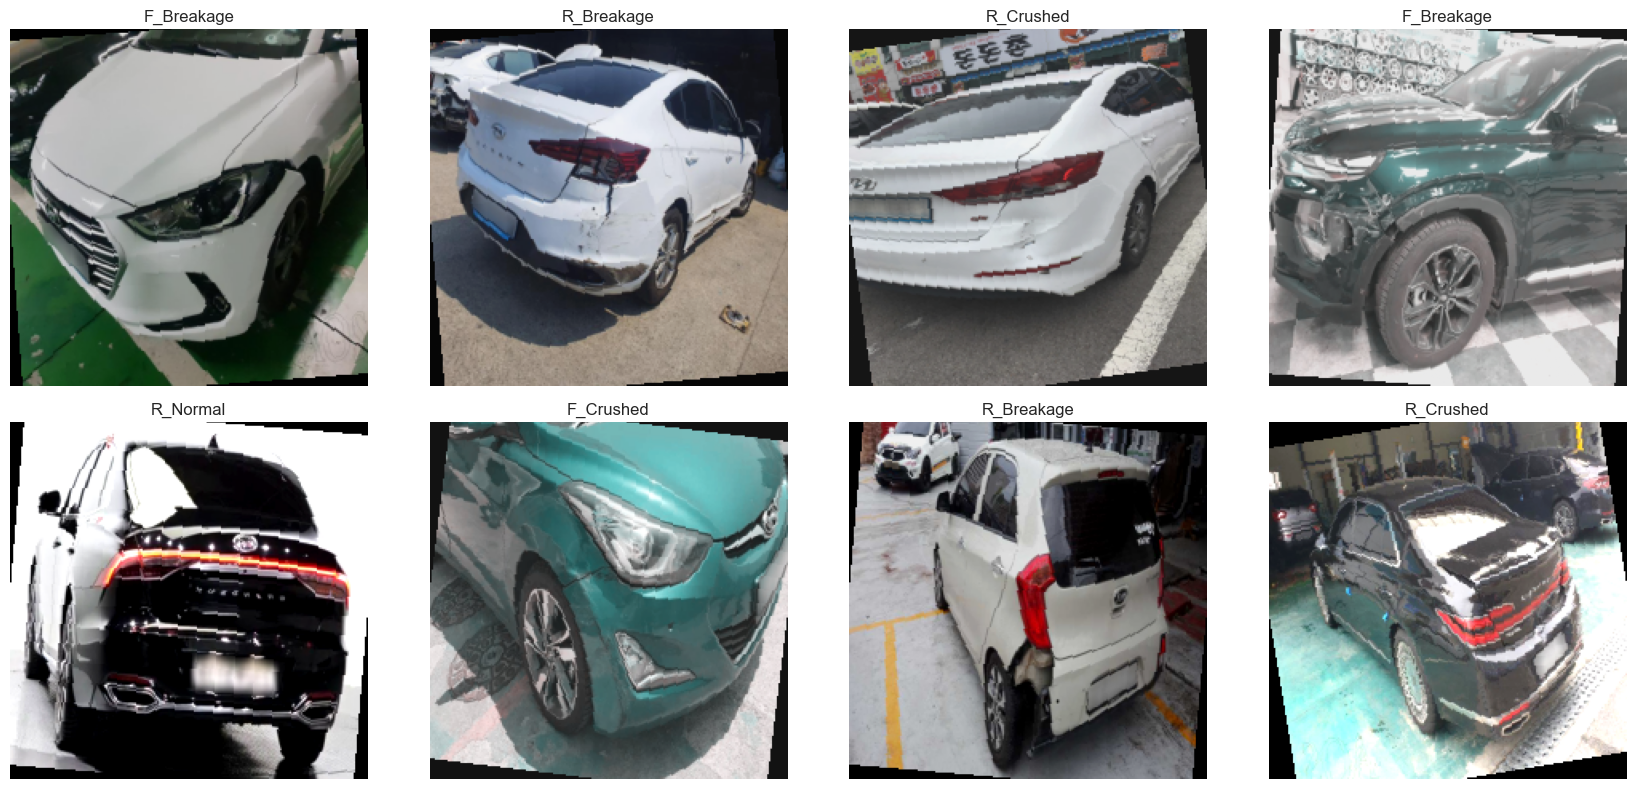

In [10]:
fig, axes = plt.subplots(2,4, figsize=(17,8))
axes = axes.flatten()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(8):
    single_image = images[i]  # Clone image to avoid modifying the original data
    for j in range(3):  # Assuming 3 channels (RGB)
        single_image[j, :, :] = single_image[j, :, :] * std[j] + mean[j]
    single_image = single_image.permute(1,2,0)
    axes[i].imshow(single_image)  #
    axes[i].set_title(class_dataset[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Get num classes or output values

In [11]:
num_classes = len(class_dataset)
num_classes

6

# Create class function for CNN Regular type

In [12]:
class CNNCarDamageDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 16, kernel_size=3,stride=1, padding=1), # 16,224,224,224
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 16, 112,112,112
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1), # 32,112,112,112
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 32, 56,56,56
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, stride=1, padding=1), # 64,56,56,56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #64,28,28,28
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        x = self.classifier(x)
        return x

In [13]:
model = CNNCarDamageDetection().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
print(model)

CNNCarDamageDetection(
  (classifier): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=6, bias=True)
  )
)


# Define train model with training and evaluation for whole processing of training --> Then get the total loss and accuracy

In [ ]:
def train_model(model, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch , (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if batch % 10 == 0:
                print(f" Batch {batch}, epoch :{epoch}, Loss: {loss.item():.4f}")
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

        model.eval()
        correct = 0
        total = 0
        total_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                total_loss += loss.item()
            accuracy = 100 * correct / total
            print(f"Total loss : {total_loss/len(val_dataset):.4f}, Validation Accuracy: {accuracy:.2f}%")

train_model(model, criterion, optimizer, epochs=5)

# Try with new class  - Adjust with Regularization methods : Add BatchNormalization, Dropout and weight_decay

In [ ]:
class CNNCarDamageDetectionWithRegularization(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 16, kernel_size=3,stride=1, padding=1), # 16,224,224,224
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 16, 112,112,112
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1), # 32,112,112,112
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 32, 56,56,56
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, stride=1, padding=1), # 64,56,56,56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #64,28,28,28
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [ ]:
model_reg = CNNCarDamageDetectionWithRegularization().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_reg.parameters(), lr=0.0001, weight_decay= 1e-4)

In [ ]:
train_model(model_reg, criterion, optimizer, epochs=5)

# Try with pretrained transfer model Efficient_b0 : Using dropout 0.5, optimizer get optimize only the unfrozen parameters.

In [ ]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Freeze all layers except the classifier
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the last layers of EfficientNet (adjust as needed)
        for param in self.model.features[5:].parameters(): # Example: unfreeze from the 6th block onwards
          param.requires_grad = True

        # Replace the final fully connected layer with a custom classifier
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) # Optimize only the unfrozen parameters

train_model(model, criterion, optimizer, epochs=8)

# Try with Pretrained ResNet 50 : Dropout 0.5

In [ ]:
# Load the pre-trained ResNet model
import torchvision.models as models

class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

# Try Optuna for Pretrained ResNet 50 --> Then get the best params

In [ ]:
import optuna

def objective(trial):
    # Hyperparameter to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.7)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # Model creation
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop (1 epoch only to minimize runtime for the search)
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation accuracy
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial)

In [23]:
best_params_ResNet={'dropout_rate': 0.37112580272910733, 'lr': 0.0010867605115576732}

# Try Pretrained transfer ResNet 50 with the best params from optuna

In [25]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=best_params_ResNet['dropout_rate']):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model_resnet = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet.parameters()), lr=best_params_ResNet['lr'])

train_model(model_resnet, criterion, optimizer, epochs=8)

 Batch 0, epoch :0, Loss: 1.8162
 Batch 10, epoch :0, Loss: 1.1248
 Batch 20, epoch :0, Loss: 0.7672
 Batch 30, epoch :0, Loss: 0.6568
 Batch 40, epoch :0, Loss: 0.5954
 Batch 50, epoch :0, Loss: 0.8948
Epoch 1/8, Loss: 0.9052
Total loss : 0.0232, Validation Accuracy: 72.35%
 Batch 0, epoch :1, Loss: 0.8519
 Batch 10, epoch :1, Loss: 1.5307
 Batch 20, epoch :1, Loss: 0.9806
 Batch 30, epoch :1, Loss: 1.0270
 Batch 40, epoch :1, Loss: 0.8753
 Batch 50, epoch :1, Loss: 0.9185
Epoch 2/8, Loss: 0.9669
Total loss : 0.0256, Validation Accuracy: 62.43%
 Batch 0, epoch :2, Loss: 0.8059
 Batch 10, epoch :2, Loss: 0.5956
 Batch 20, epoch :2, Loss: 0.9318
 Batch 30, epoch :2, Loss: 0.5361
 Batch 40, epoch :2, Loss: 0.9182
 Batch 50, epoch :2, Loss: 0.6996
Epoch 3/8, Loss: 0.6758
Total loss : 0.0196, Validation Accuracy: 70.78%
 Batch 0, epoch :3, Loss: 0.7093
 Batch 10, epoch :3, Loss: 0.8001
 Batch 20, epoch :3, Loss: 0.5224
 Batch 30, epoch :3, Loss: 0.7319
 Batch 40, epoch :3, Loss: 0.6242
 Ba

([2,
  3,
  2,
  0,
  4,
  2,
  2,
  2,
  5,
  4,
  1,
  1,
  4,
  2,
  1,
  0,
  0,
  0,
  1,
  2,
  0,
  2,
  5,
  0,
  1,
  4,
  4,
  0,
  0,
  3,
  2,
  1,
  2,
  0,
  5,
  3,
  5,
  0,
  2,
  4,
  1,
  0,
  1,
  0,
  2,
  0,
  4,
  2,
  1,
  5,
  0,
  0,
  0,
  4,
  2,
  1,
  1,
  0,
  2,
  4,
  2,
  3,
  4,
  0,
  0,
  4,
  1,
  1,
  0,
  2,
  5,
  5,
  0,
  2,
  4,
  0,
  2,
  4,
  0,
  5,
  2,
  0,
  1,
  3,
  2,
  4,
  2,
  2,
  0,
  5,
  2,
  1,
  2,
  3,
  2,
  4,
  0,
  2,
  1,
  5,
  5,
  5,
  0,
  0,
  1,
  3,
  0,
  0,
  1,
  5,
  2,
  0,
  0,
  0,
  4,
  1,
  5,
  0,
  4,
  2,
  0,
  0,
  4,
  3,
  5,
  0,
  0,
  3,
  1,
  1,
  4,
  5,
  2,
  0,
  4,
  3,
  4,
  4,
  2,
  3,
  4,
  4,
  0,
  4,
  2,
  0,
  2,
  4,
  0,
  2,
  4,
  4,
  0,
  4,
  5,
  3,
  0,
  2,
  5,
  0,
  4,
  3,
  3,
  0,
  2,
  1,
  0,
  1,
  5,
  3,
  2,
  2,
  2,
  4,
  3,
  0,
  1,
  4,
  4,
  5,
  1,
  5,
  4,
  2,
  2,
  0,
  2,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  4,
  1,
  3,
  2,
  0,
  0,


# Try optuna with Efficient pretrained model

In [ ]:
# prompt: write optuna for my class CarClassifierEfficientNet

def objective(trial):
    # Hyperparameter to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.7)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # Model creation
    model = CarClassifierEfficientNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop (1 epoch only to minimize runtime for the search)
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation accuracy
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial)

best_params = study.best_params
print(best_params)

In [ ]:
best_params_efficient=best_params
best_params_efficient

# Setup train model again to get predict and labels for report accuracy and confusion matrics

In [15]:
def train_model(model, criterion, optimizer, epochs):
    total_val = []
    total_prediction = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch , (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if batch % 10 == 0:
                print(f" Batch {batch}, epoch :{epoch}, Loss: {loss.item():.4f}")
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

        model.eval()
        correct = 0
        total = 0
        total_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)


                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                total_prediction.extend(predicted.cpu().numpy())
                total_val.extend(labels.cpu().numpy())

                total_loss += loss.item()
            accuracy = 100 * correct / total
            print(f"Total loss : {total_loss/len(val_dataset):.4f}, Validation Accuracy: {accuracy:.2f}%")

    return total_prediction, total_val

# Set up class with the best params from Pretrained optuna then get the reults of accuracy, predict and labels

In [16]:
best_params_efficient = {'dropout_rate': 0.560122966606635, 'lr': 0.0005842324132540079}

In [19]:

class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=best_params_efficient['dropout_rate']):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Freeze all layers except the classifier
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the last layers of EfficientNet (adjust as needed)
        for param in self.model.features[5:].parameters(): # Example: unfreeze from the 6th block onwards
          param.requires_grad = True

        # Replace the final fully connected layer with a custom classifier
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=best_params_efficient['lr']) # Optimize only the unfrozen parameters

prediction, labels = train_model(model, criterion, optimizer, epochs=5)

 Batch 0, epoch :0, Loss: 1.7955
 Batch 10, epoch :0, Loss: 1.1868
 Batch 20, epoch :0, Loss: 0.9238
 Batch 30, epoch :0, Loss: 0.9782
 Batch 40, epoch :0, Loss: 0.8067
 Batch 50, epoch :0, Loss: 0.5515
Epoch 1/5, Loss: 0.9917
Total loss : 0.0199, Validation Accuracy: 70.96%
 Batch 0, epoch :1, Loss: 0.6042
 Batch 10, epoch :1, Loss: 0.4206
 Batch 20, epoch :1, Loss: 0.9584
 Batch 30, epoch :1, Loss: 0.6928
 Batch 40, epoch :1, Loss: 0.7719
 Batch 50, epoch :1, Loss: 0.3114
Epoch 2/5, Loss: 0.6691
Total loss : 0.0187, Validation Accuracy: 73.04%
 Batch 0, epoch :2, Loss: 0.3964
 Batch 10, epoch :2, Loss: 0.4177
 Batch 20, epoch :2, Loss: 0.6520
 Batch 30, epoch :2, Loss: 0.5341
 Batch 40, epoch :2, Loss: 0.5650
 Batch 50, epoch :2, Loss: 0.9611
Epoch 3/5, Loss: 0.5085
Total loss : 0.0225, Validation Accuracy: 67.83%
 Batch 0, epoch :3, Loss: 0.6309
 Batch 10, epoch :3, Loss: 0.3885
 Batch 20, epoch :3, Loss: 0.7586
 Batch 30, epoch :3, Loss: 0.7241
 Batch 40, epoch :3, Loss: 0.5286
 Ba

In [22]:
model

CarClassifierEfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

### Try to get the accuracy from 25 images randomly

In [ ]:
import random

def predict_random_images(model, dataset, class_dataset, num_images=25):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_images)
    images, labels = zip(*[dataset[i] for i in random_indices])

    images = torch.stack(images).to(device)
    labels = torch.Tensor(labels).long().to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    for i, (img, pred, label, ax) in enumerate(zip(images, predictions, labels, axes)):
        img = img.cpu()
        for j in range(3):
            img[j] = img[j] * std[j] + mean[j]
        img = img.permute(1, 2, 0).numpy()

        ax.imshow(img)
        ax.set_title(f"Pred: {class_dataset[pred]}, True: {class_dataset[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

predict_random_images(model, dataset, class_dataset)

# The accuracy is around 80% and with the best param from optuna for pretrained model transfer Efficient.

# Check report accuracy

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
report = classification_report(labels, prediction, target_names=class_dataset)
print(report)

In [ ]:
cm = confusion_matrix(labels, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dataset, yticklabels=class_dataset)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Model Efficient

In [26]:
model_resnet

CarClassifierResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [27]:
torch.save(model_resnet.state_dict(), 'streamlit_app/model_resnet.pth')